# Лабораторная работа №4  
## Реализация алгоритма Policy Iteration

На основе рассмотренного на лекции примера реализуйте алгоритм Policy Iteration для любой среды обучения с подкреплением (кроме рассмотренной на лекции среды Toy Text / Frozen Lake) из библиотеки Gym (или аналогичной библиотеки).

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import random

### Описание среды `Blackjack-v1`

* Игрок и дилер получают по 2 карты.
* Игрок может "взять карту" (hit) или "остановиться" (stick).
* Цель — набрать как можно ближе к 21, не превысив его.
* Есть понятие usable ace — если туз можно считать за 11 без перебора.
* Награды:

  * +1 — победа игрока
  * 0 — ничья
  * -1 — проигрыш


In [2]:
# Создаем среду Blackjack
env = gym.make('Blackjack-v1', sab=True)  # `sab=True` включает действия дилера по правилам Стэнфорда

### Описание алгоритма **Policy Iteration**

Policy Iteration — это табличный метод решения задач обучения с подкреплением в средах со статическим пространством состояний.

Он состоит из двух шагов:

1. **Оценка политики (Policy Evaluation):**
   Вычисляется функция ценности для текущей стратегии.
2. **Улучшение политики (Policy Improvement):**
   На основе функции ценности пересматривается стратегия, выбирая лучшие действия.

Эти шаги повторяются, пока стратегия не перестанет меняться — это и есть оптимальная политика.

In [3]:
# Получаем все возможные состояния
def all_states(env):
    states = []
    for player_sum in range(4, 32):  # 4-31 — возможные значения руки игрока
        for dealer_card in range(1, 11):  # 1-10 — возможные карты дилера
            for usable_ace in [False, True]:
                states.append((player_sum, dealer_card, usable_ace))
    return states

states = all_states(env)
actions = [0, 1]  # 0: стоять (stick), 1: взять карту (hit)

# Инициализация произвольной политики
policy = defaultdict(lambda: 0)  # Изначально все действия — стоять

# Инициализация функции ценности
V = defaultdict(float)
gamma = 1.0  # Фактор дисконтирования

# Сохраняем статистику
delta_history = []
policy_changes_history = []

In [4]:
# Функция для симуляции переходов из заданного состояния и действия
def sample_transitions(env, state, action, n_samples=100):
    outcomes = []
    for _ in range(n_samples):
        seed = random.randint(0, 10000)
        env.reset(seed=seed)
        env.player = [state[0] - 10 if state[2] else state[0]]
        if state[2]:
            env.player.append(1)
        env.dealer = [state[1]]
        next_state, reward, done, _, _ = env.step(action)
        outcomes.append((next_state, reward, done))
    return outcomes

# Оценка текущей стратегии
def policy_evaluation(policy, V, env, theta=1e-2, gamma=1.0, n_samples=100, max_iterations=20):
    deltas = []
    for _ in range(max_iterations):
        delta = 0
        for state in states:
            v = V[state]
            action = policy[state]
            transitions = sample_transitions(env, state, action, n_samples)
            V[state] = np.mean([
                reward + gamma * V[next_state] * (not done)
                for next_state, reward, done in transitions
            ])
            delta = max(delta, abs(v - V[state]))
        deltas.append(delta)
        if delta < theta:
            break
    delta_history.append(deltas[-1])
    return V

# Улучшение стратегии на основе оценки ценности
def policy_improvement(V, env, gamma=1.0, epsilon=0.05):
    policy_stable = True
    policy_changes = 0
    for state in states:
        old_action = policy[state]
        action_values = np.zeros(len(actions))
        for a in actions:
            transitions = sample_transitions(env, state, a)
            action_values[a] = np.mean([
                reward + gamma * V[next_state] * (not done)
                for next_state, reward, done in transitions
            ])
        if random.random() < epsilon:
            best_action = random.choice(actions)
        else:
            best_action = np.argmax(action_values)
        policy[state] = best_action
        if old_action != best_action:
            policy_stable = False
            policy_changes += 1
    policy_changes_history.append(policy_changes)
    return policy, policy_stable

# Главная функция Policy Iteration
def policy_iteration(env, gamma=1.0, max_policy_iter=20):
    V = defaultdict(float)
    policy = defaultdict(lambda: random.choice(actions))  # случайная инициализация
    for iteration in range(max_policy_iter):
        print(f"Итерация {iteration}")
        V = policy_evaluation(policy, V, env, gamma=gamma)
        policy, policy_stable = policy_improvement(V, env, gamma=gamma)
        print(f"  Макс. изменение V: {delta_history[-1]:.5f}")
        print(f"  Изменений в политике: {policy_changes_history[-1]}")
        if policy_stable:
            print("Политика стабилизировалась.")
            break
    return policy, V

In [5]:
# Запуск алгоритма
optimal_policy, optimal_value = policy_iteration(env)

Итерация 0
  Макс. изменение V: 0.42000
  Изменений в политике: 15
Итерация 1
  Макс. изменение V: 0.40000
  Изменений в политике: 33
Итерация 2
  Макс. изменение V: 0.49000
  Изменений в политике: 32
Итерация 3
  Макс. изменение V: 0.52000
  Изменений в политике: 24
Итерация 4
  Макс. изменение V: 0.47000
  Изменений в политике: 27
Итерация 5
  Макс. изменение V: 0.39000
  Изменений в политике: 32
Итерация 6
  Макс. изменение V: 0.43000
  Изменений в политике: 31
Итерация 7
  Макс. изменение V: 0.50000
  Изменений в политике: 25
Итерация 8
  Макс. изменение V: 0.45000
  Изменений в политике: 29
Итерация 9
  Макс. изменение V: 0.41000
  Изменений в политике: 23
Итерация 10
  Макс. изменение V: 0.49000
  Изменений в политике: 16
Итерация 11
  Макс. изменение V: 0.45000
  Изменений в политике: 19
Итерация 12
  Макс. изменение V: 0.53000
  Изменений в политике: 25
Итерация 13
  Макс. изменение V: 0.47000
  Изменений в политике: 23
Итерация 14
  Макс. изменение V: 0.47000
  Изменений в пол

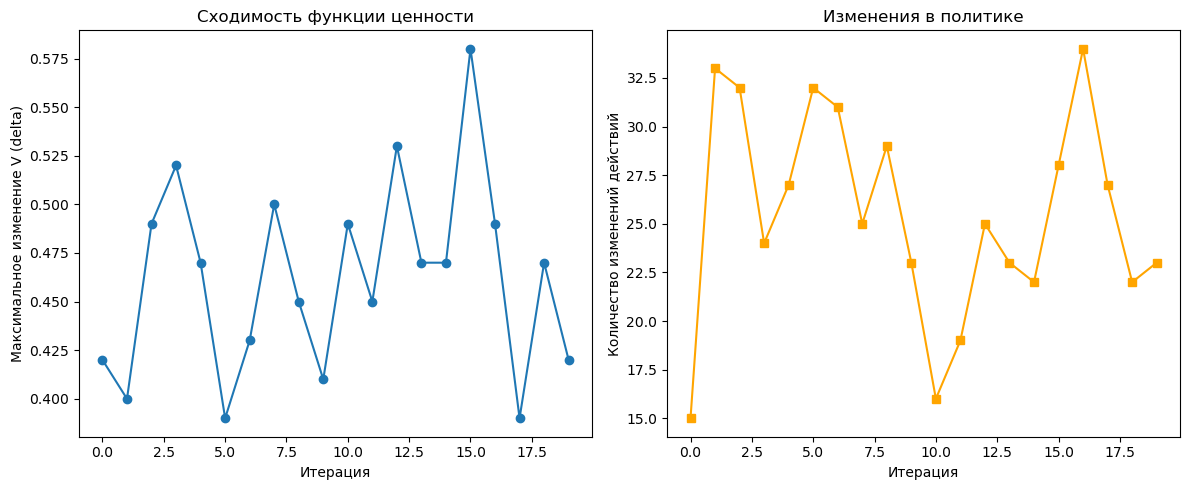

In [6]:
# Визуализация обучения
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(delta_history, marker='o')
plt.title("Сходимость функции ценности")
plt.xlabel("Итерация")
plt.ylabel("Максимальное изменение V (delta)")

plt.subplot(1, 2, 2)
plt.plot(policy_changes_history, marker='s', color='orange')
plt.title("Изменения в политике")
plt.xlabel("Итерация")
plt.ylabel("Количество изменений действий")

plt.tight_layout()
plt.show()

In [7]:
# Печать итоговой политики
def print_policy(policy):
    print("Оптимальная политика (player sum от 12 до 21):")
    for player_sum in range(12, 22):
        row = ''
        for dealer_card in range(1, 11):
            action = policy[(player_sum, dealer_card, False)]
            row += 'S' if action == 0 else 'H'
            row += ' '
        print(f'{player_sum}: {row}')

print_policy(optimal_policy)

Оптимальная политика (player sum от 12 до 21):
12: S S S S S S S S S S 
13: S S S S S S S S S S 
14: S S S S S S S S S S 
15: S S S S S S S S S S 
16: S S S S S H S S S S 
17: S S S S S S S S S S 
18: S S S S S S H S S S 
19: S S S S S S S S S S 
20: S S S S S S S S S S 
21: S S S S S S S S S S 


Алгоритм Policy Iteration успешно нашёл оптимальную стратегию для игры в блэкджек.

Он показал, при каких суммах и картах игроку стоит брать карту (H) или стоять (S).

Эта стратегия учитывает текущую руку, карту дилера и наличие туза как 11.